# Mortality risk prediction training

# Imports

In [1]:
import os
import pickle
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics

sys.path.append("..")
sys.path.append("../..")
from cyclops.utils.file import load_dataframe, save_dataframe
from drift_detection.baseline_models.temporal.pytorch.optimizer import Optimizer
from drift_detection.baseline_models.temporal.pytorch.utils import *

In [2]:
from cyclops.processors.column_names import EVENT_NAME

# IMPORT THIS FROM CONSTANTS
OUTCOME_DEATH_TEMP = "outcome_death_temp"

# Setup

In [3]:
batch_size = 64

In [4]:
output_dim = 1
hidden_dim = 64
layer_dim = 2
dropout = 0.2
n_epochs = 10  # 256
learning_rate = 2e-3
weight_decay = 1e-6
last_timestep_only = False

## Data

In [5]:
# Load data (deserialize)
def load_pickle(file):
    if not file.endswith(".pkl"):
        file += ".pkl"

    with open(file, "rb") as handle:
        return pickle.load(handle)

In [31]:
def prep(vec):
    arr = np.squeeze(vec.data, 0)
    arr = np.moveaxis(arr, 2, 0)
    arr = np.nan_to_num(arr)
    return arr

In [32]:
X_train_vec = load_pickle("comb_train_X")
y_train_vec = load_pickle("comb_train_y").take_with_index(
    EVENT_NAME, [OUTCOME_DEATH_TEMP]
)
X_train = prep(X_train_vec.data)
y_train = prep(y_train_vec.data)
X_train.shape, y_train.shape

((3, 44202, 93), (3, 44202, 1))

In [33]:
X_val_vec = load_pickle("comb_val_X")
y_val_vec = load_pickle("comb_val_y").take_with_index(EVENT_NAME, [OUTCOME_DEATH_TEMP])
X_val = prep(X_val_vec.data)
y_val = prep(y_val_vec.data)
X_val.shape, y_val.shape

((3, 12629, 93), (3, 12629, 1))

In [34]:
X_test_vec = load_pickle("comb_test_X")
y_test_vec = load_pickle("comb_test_y").take_with_index(
    EVENT_NAME, [OUTCOME_DEATH_TEMP]
)
X_test = prep(X_test_vec.data)
y_test = prep(y_test_vec.data)
X_test.shape, y_test.shape

((3, 6315, 93), (3, 6315, 1))

In [35]:
train_dataset = get_data(X_train, y_train)
train_loader = train_dataset.to_loader(batch_size, shuffle=True)

val_dataset = get_data(X_val, y_val)
val_loader = val_dataset.to_loader(batch_size)

test_dataset = get_data(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [36]:
n_features = X_train.shape[2]
timesteps = X_train.shape[1]

## Model

In [25]:
device = get_device()
device

device(type='cuda')

In [26]:
model_params = {
    "device": device,
    "input_dim": n_features,
    "hidden_dim": hidden_dim,
    "layer_dim": layer_dim,
    "output_dim": output_dim,
    "dropout_prob": dropout,
    "last_timestep_only": last_timestep_only,
}

In [27]:
model = get_temporal_model("lstm", model_params).to(device)
model

LSTMModel(
  (lstm): LSTM(93, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## Training and validation

In [28]:
loss_fn = nn.BCEWithLogitsLoss(reduction="none")
optimizer = optim.Adagrad(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=128, gamma=0.5)
activation = nn.Sigmoid()
opt = Optimizer(
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    activation=activation,
    lr_scheduler=lr_scheduler,
)

# Train

[1/10] Training loss: 0.7154	 Validation loss: 0.6445
[2/10] Training loss: 0.6456	 Validation loss: 0.5923
[3/10] Training loss: 0.5940	 Validation loss: 0.5407
[4/10] Training loss: 0.5432	 Validation loss: 0.4860
[5/10] Training loss: 0.4891	 Validation loss: 0.4273
[6/10] Training loss: 0.4314	 Validation loss: 0.3661
[7/10] Training loss: 0.3710	 Validation loss: 0.3067
[8/10] Training loss: 0.3117	 Validation loss: 0.2543
[9/10] Training loss: 0.2589	 Validation loss: 0.2131
[10/10] Training loss: 0.2170	 Validation loss: 0.1840


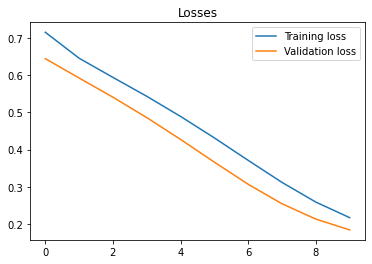

In [ ]:
opt.train(
    train_loader,
    val_loader,
    batch_size=batch_size,
    n_epochs=n_epochs,
    n_features=n_features,
    timesteps=timesteps,
)
opt.plot_losses()

# Testing, metrics

In [17]:
y_test_labels, y_pred_values, y_pred_labels = opt.evaluate(
    test_loader, batch_size=1, n_features=n_features, timesteps=timesteps
)

y_pred_values = y_pred_values[y_test_labels != -1]
y_pred_labels = y_pred_labels[y_test_labels != -1]
y_test_labels = y_test_labels[y_test_labels != -1]

confusion_matrix = metrics.confusion_matrix(y_test_labels, y_pred_labels)
print(confusion_matrix)

pred_metrics = print_metrics_binary(y_test_labels, y_pred_values, y_pred_labels)
prec = (pred_metrics["prec0"] + pred_metrics["prec1"]) / 2
rec = (pred_metrics["rec0"] + pred_metrics["rec1"]) / 2
print(f"Precision: {prec}")
print(f"Recall: {rec}")

RuntimeError: shape '[1, 44202, 93]' is invalid for input of size 587295

## Plot confusion matrix

In [ ]:
def plot_confusion_matrix(confusion_matrix, class_names):
    confusion_matrix = (
        confusion_matrix.astype("float") / confusion_matrix.sum(axis=1)[:, np.newaxis]
    )

    layout = {
        "title": "Confusion Matrix",
        "xaxis": {"title": "Predicted value"},
        "yaxis": {"title": "Real value"},
    }

    fig = go.Figure(
        data=go.Heatmap(
            z=confusion_matrix,
            x=class_names,
            y=class_names,
            hoverongaps=False,
            colorscale="Greens",
        ),
        layout=layout,
    )
    fig.update_layout(height=512, width=1024)
    fig.show()


plot_confusion_matrix(
    confusion_matrix, ["low risk of mortality", "high risk of mortality"]
)

## Compute AUROC across timesteps

In [ ]:
y_test_labels, y_pred_values, y_pred_labels = opt.evaluate(
    test_loader, batch_size=1, n_features=n_features, timesteps=timesteps, flatten=False
)

num_timesteps = y_pred_labels.shape[1]
auroc_timesteps = []
for i in range(num_timesteps):
    labels = y_test_labels[:, i]
    pred_vals = y_pred_values[:, i]
    preds = y_pred_labels[:, i]
    pred_vals = pred_vals[labels != -1]
    preds = preds[labels != -1]
    labels = labels[labels != -1]
    pred_metrics = print_metrics_binary(labels, pred_vals, preds, verbose=False)
    auroc_timesteps.append(pred_metrics["auroc"])


prediction_hours = list(range(24, 168, 24))
fig = go.Figure(
    data=[go.Bar(x=prediction_hours, y=auroc_timesteps, name="model confidence")]
)

fig.update_xaxes(tickvals=prediction_hours)
fig.update_yaxes(range=[min(auroc_timesteps) - 0.05, max(auroc_timesteps) + 0.05])

fig.update_layout(
    title="AUROC split by no. of hours after admission",
    autosize=False,
    xaxis_title="No. of hours after admission",
)
fig.show()

## WIP: Compute accuracy across lead times

In [ ]:
# BASE_DATA_PATH = "/mnt/nfs/project/delirium/drift_exp/risk_of_mortality"

# combined_events = load_dataframe(os.path.join(BASE_DATA_PATH, "combined_events"))
# timestep_end_timestamps = load_dataframe(os.path.join(BASE_DATA_PATH, "aggmeta_end_ts"))

# mortality_events = combined_events.loc[combined_events["event_name"] == "death"]

# y_test_labels, y_pred_values, y_pred_labels = opt.evaluate(
#     test_loader, batch_size=1, n_features=n_features, timesteps=timesteps, flatten=False
# )
# train_val_test_ids = load_dataframe(os.path.join(BASE_DATA_PATH, "train_val_test_ids"))
# test_ids = train_val_test_ids["test"].dropna()

# num_timesteps = y_pred_labels.shape[1]
# acc_timesteps = []
# for timestep in range(num_timesteps):
#     labels = y_test_labels[:, timestep]
#     pred_vals = y_pred_values[:, timestep]
#     preds = y_pred_labels[:, timestep]

#     is_correct_timestep = []
#     for enc_id in test_ids:
#         timestep_end_timestamp = timestep_end_timestamps.loc[enc_id, timestep]
#         mortality_timestamp = mortality_events.loc[mortality_events["encounter_id"] == enc_id]["discharge_timestamp"]
#         lead_time = mortality_timestamp - timestep_end_timestamp
#         print(timestep_end_timestamp, mortality_timestamp)
#         if (lead_time > pd.to_timedelta(0, unit="h")).all():
#             label_ = labels[test_ids.index(enc_id)]
#             pred_ = preds[test_ids.index(enc_id)]

#             if label_ == 1:
#                 if label_ == pred_:
#                     is_correct_timestep.append(1)
#                 else:
#                     is_correct_timestep.append(0)

#     acc_timesteps.append(sum(is_correct_timestep) / len(is_correct_timestep))

## Visualize model outputs and labels

In [ ]:
def plot_risk_mortality(predictions, labels=None):
    prediction_hours = list(range(24, 168, 24))
    is_mortality = labels == 1
    after_discharge = labels == -1
    label_h = -0.2
    fig = go.Figure(
        data=[
            go.Scatter(
                mode="markers",
                x=prediction_hours,
                y=[label_h for x in prediction_hours],
                line=dict(color="Black"),
                name="low risk of mortality label",
                marker=dict(color="Green", size=20, line=dict(color="Black", width=2)),
            ),
            go.Scatter(
                mode="markers",
                x=[prediction_hours[i] for i, v in enumerate(is_mortality) if v],
                y=[label_h for _, v in enumerate(is_mortality) if v],
                line=dict(color="Red"),
                name="high risk of mortality label",
                marker=dict(color="Red", size=20, line=dict(color="Black", width=2)),
            ),
            go.Scatter(
                mode="markers",
                x=[prediction_hours[i] for i, v in enumerate(after_discharge) if v],
                y=[label_h for _, v in enumerate(after_discharge) if v],
                line=dict(color="Grey"),
                name="post discharge label",
                marker=dict(color="Grey", size=20, line=dict(color="Black", width=2)),
            ),
            go.Bar(
                x=prediction_hours,
                y=predictions,
                marker_color="Red",
                name="model confidence",
            ),
        ]
    )
    fig.update_yaxes(range=[label_h, 1])
    fig.update_xaxes(tickvals=prediction_hours)
    fig.update_xaxes(showline=True, linewidth=2, linecolor="black")

    fig.add_hline(y=0.5)

    fig.update_layout(
        title="Model output visualization",
        autosize=False,
        xaxis_title="No. of hours after admission",
        yaxis_title="Model confidence",
    )

    return fig


mortality_cases = [idx for idx, v in enumerate(y_test_labels)]
sample_idx = random.choice(mortality_cases)
fig = plot_risk_mortality(
    y_pred_values[sample_idx].squeeze(), y_test_labels[sample_idx]
)
fig.show()

## Journal of some experiments


<table>
    <thead>
        <tr>
            <th>Split</th>
            <th>Model</th>
            <th>AUROC</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=4>Random</td>
        </tr>
        <tr>
            <td>LSTM</td>
            <td><b>0.8005</b></td>
        </tr>
          <tr style="border-bottom:1px solid black">
            <td colspan="100%"></td>
          </tr>
          <tr> ... </tr>
    </tbody>
</table>